## MSDS 7331: Data Mining
## Lab 2: Classification
## 7 July 2019
## Authors: Meredith Ludlow, Anand Rajan, Kristen Rollins, and Tej Tenmattam

---

# Data Preparation Part 1

<div class="alert alert-block alert-info">
<b>Rubric 1:</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
</div>

The two classification tasks for our 2017 census dataset are to predict whether a given census tract has a high or a low unemployment rate, as well as a high or low child poverty rate, based on other relevant factors. This is an important task, as it enables certain areas to be flagged as needing economic development or aid. Below, we first prepared our data for classification by cleaning it (in the same way as Lab 1), as well as removing unnecessary and redundant variables.

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set seaborn plot styles
sns.set_style('darkgrid')
sns.set_color_codes('muted')

import warnings
warnings.filterwarnings("ignore") # ignore warnings for clean report

# df.head() displays all the columns without truncating
pd.set_option('display.max_columns', None)

# read csv file as pandas dataframe
df_17_census = pd.read_csv('Data/acs2017_census_tract_data.csv')

In [2]:
# Clean dataset as in lab 1
df_17_census.set_index('TractId', inplace=True) # set tract id as index

# Drop tracts where population is 0
df_17_cln = df_17_census.drop(df_17_census[df_17_census.TotalPop == 0].index)

# Drop tracts where child poverty or unemployment is null
df_17_cln = df_17_cln[np.isfinite(df_17_cln['ChildPoverty'])]
df_17_cln = df_17_cln[np.isfinite(df_17_cln['Unemployment'])]

# Impute to the median by each state
df_grouped = df_17_cln.groupby('State').transform(lambda x: x.fillna(x.median()))
df_17_cln['Income'] = df_grouped['Income']
df_17_cln['IncomeErr'] = df_grouped['IncomeErr']

# Impute remaining values to the overall median
df_17_cln = df_17_cln.fillna(df_17_cln.median())

In [3]:
df_17_cln.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.00000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000,72889.000000
mean,4438.372759,2182.350698,2256.022061,17.290081,61.312817,13.268165,0.729703,4.752853,0.146698,3137.878459,61111.961002,9694.920825,30702.626734,4259.381073,16.067164,21.155081,35.566003,18.855030,23.407072,9.256663,12.915429,75.823635,9.323555,5.387234,2.95396,1.888721,4.623234,26.078983,2078.009535,79.506605,14.151449,6.170819,0.171328,7.235223
std,2192.532931,1101.516460,1126.275010,23.097490,30.635700,21.598962,4.525143,8.992743,1.023074,1514.686755,30492.084659,6135.953813,16059.781976,3019.532445,12.514595,18.643563,15.093914,8.037855,5.653534,5.979854,7.629365,15.062128,5.167761,11.659900,5.39858,2.518341,3.821944,7.101069,1121.667248,8.017414,7.224480,3.846069,0.455440,5.177195
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2692.000000,728.000000,949.000000,308.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2953.000000,1438.000000,1491.000000,2.600000,38.100000,0.800000,0.000000,0.200000,0.000000,2093.000000,40400.000000,5740.000000,20603.000000,2507.000000,6.900000,6.200000,24.700000,13.300000,19.700000,5.000000,7.100000,72.300000,5.800000,0.000000,0.40000,0.400000,2.000000,21.100000,1302.000000,75.300000,9.300000,3.500000,0.000000,3.900000
50%,4133.000000,2022.000000,2100.000000,7.400000,70.400000,3.800000,0.000000,1.500000,0.000000,2924.000000,54434.000000,8273.000000,27242.000000,3405.000000,12.600000,16.300000,33.300000,17.700000,23.200000,8.400000,11.800000,79.900000,8.500000,1.000000,1.40000,1.200000,3.800000,25.400000,1913.000000,80.600000,13.000000,5.500000,0.000000,6.000000
75%,5530.000000,2717.000000,2815.000000,21.100000,87.700000,14.500000,0.400000,5.000000,0.000000,3920.000000,74673.000000,11899.000000,36429.000000,4965.000000,21.800000,31.600000,44.900000,23.300000,26.900000,12.500000,17.500000,84.900000,11.900000,4.600000,3.30000,2.500000,6.300000,30.300000,2649.000000,85.000000,17.600000,8.000000,0.000000,9.000000
max,65528.000000,32266.000000,33262.000000,100.000000,100.000000,100.000000,100.000000,91.400000,71.900000,39389.000000,249750.000000,153365.000000,220253.000000,84414.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,73.900000,28945.000000,100.000000,100.000000,100.000000,22.300000,100.000000


In [4]:
# Categorize the unemployed percentages into binary categories
# Make cutoff using median of clean dataset, so groups are roughly equal
df_17_cln['HighUnemployment'] = pd.cut(df_17_cln.Unemployment,[-1,6,101],labels=[0,1])     
df_17_cln.HighUnemployment = df_17_cln.HighUnemployment.astype(np.int)
# 0 indicates low unemployment rate, 1 indicates high unemployment rate

# Categorize the child poverty percentages into binary categories
# Make cutoff using median of clean dataset, so groups are roughly equal
df_17_cln['HighChildPoverty'] = pd.cut(df_17_cln.ChildPoverty,[-1,16.3,101],labels=[0,1])
df_17_cln.HighChildPoverty = df_17_cln.HighChildPoverty.astype(np.int)
# 0 indicates low child poverty rate, 1 indicates high child poverty rate

df_17_cln.info() # matches cleaned dataset from lab 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 38 columns):
State               72889 non-null object
County              72889 non-null object
TotalPop            72889 non-null int64
Men                 72889 non-null int64
Women               72889 non-null int64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null int64
Income              72889 non-null float64
IncomeErr           72889 non-null float64
IncomePerCap        72889 non-null float64
IncomePerCapErr     72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 

At this point we have a clean dataset with no missing values, that matches the info from the cleaned dataset we used in Lab 1. Our target variables are "HighUnemployment" and "HighChildPoverty", which we encoded so that 1 signifies a tract with a high unemployment rate or high child poverty rate and a 0 indicates low unemployment or low child poverty respectively. We created the cutoff between high and low unemployment to be 6 percent, which was the median value for the unemployment attribute. Similarly, we used the median value of 16.3 as the cutoff for high and low child poverty rates. By using the median to separate the groups, the classes will be of roughly the same size.

Since this dataset has 38 variables, next we eliminate some unnecessary and redundant variables to cut down on the high dimensionality of the dataset. Here we eliminate variables based on the pairwise correlation plot we created in Lab 1 and intuition. In the Mini Lab, we further reduced the dataset down to only 6 important features based on PCA, but the models using that dataset were not as accurate. Thus we will use this "full" dataset of 28 variables throughout this lab.

Here we also do a bit of scaling, so that the previously integer attributes are now percentages. In this way most of the predictors are percentages of the total population. However, we will do further scaling when creating our models.

In [5]:
# Create dataframe to use in logistic and SVM models
df_17_model = df_17_cln.copy()

# Eliminate non-useful and redundant variables
del df_17_model['State'] # encoding would result in too many added variables
del df_17_model['County'] # encoding would result in too many added variables
del df_17_model['Men'] # redundant to keep men and women
del df_17_model['Unemployment'] # already encoded to binary
del df_17_model['ChildPoverty'] # already encoded to binary

# Eliminate more variables based on correlation plot (could maybe remove more)
del df_17_model['IncomeErr'] # only need to keep one income-related variable
del df_17_model['IncomePerCap'] # only need to keep one income-related variable
del df_17_model['IncomePerCapErr'] # only need to keep one income-related variable
del df_17_model['Transit'] # drive and transit were essentially inverses
del df_17_model['PublicWork'] # private and public work were essentially inverses

# All remaining variables are ints or floats so we do not have to do one-hot encoding

# Convert columns to percentages for consistency
df_17_model['Women'] = round(df_17_model['Women']/df_17_model['TotalPop']*100,1)
df_17_model['VotingAgeCitizen'] = round(df_17_model['VotingAgeCitizen']/df_17_model['TotalPop']*100,1)
df_17_model['Employed'] = round(df_17_model['Employed']/df_17_model['TotalPop']*100,1)

print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp         72889 non-null float64
WorkAtHome        

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment,HighChildPoverty
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0,1
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0,1
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0,1
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1,0
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0,1


In [6]:
# create X and y variables to use in models
# y_u is for unemployment, y_cp is for child poverty
if 'HighUnemployment' in df_17_model:
    y_u = df_17_model['HighUnemployment'].values # get the labels we want
    del df_17_model['HighUnemployment'] # get rid of the class label
if 'HighChildPoverty' in df_17_model:
    y_cp = df_17_model['HighChildPoverty'].values # get the labels we want
    del df_17_model['HighChildPoverty'] # get rid of the class label
X = df_17_model.values # use everything else to predict

# Data Preparation Part 2

<div class="alert alert-block alert-info">
<b>Rubric 2:</b> Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
</div>

Our final dataset used for classification is very similar to the full dataset provided by the U.S. Census Bureau. The differences are that a few variables have been removed due to redundancy, three variables have been converted to percentages rather than counts (Women, VotingAgeCitizen, and Employed), and our target class variables of Unemployment and ChildPoverty have been converted to binary indicator variables.

| Attribute | Data Type | Description |
|-----------|-----------|-------------|
| TotalPop | Integer | Total population of the census area |
| Women | Decimal | Percentage of total population that are women |
| Hispanic | Decimal | Percentage of population that is Hispanic/Latino |
| White | Decimal | Percentage of population that is white |
| Black | Decimal | Percentage of population that is black |
| Native | Decimal | Percent of population that is Native American |
| Asian | Decimal | Percent of population that is Asian |
| Pacific | Decimal | Percent of population that is Native Hawaiian or other Pacific Islander |
| VotingAgeCitizen | Decimal | Percentage of population that are voting age citizens |
| Income | Decimal | Median household income in USD ($) |
| Poverty | Decimal | Percentage of population under the poverty level |
| Professional | Decimal | Percent employed in management, business, science, and arts |
| Service | Decimal | Percent employed in service jobs |
| Office | Decimal | Percent employed in sales and office jobs |
| Construction | Decimal | Percent employed in natural resources, construction, and maintenance |
| Production | Decimal | Percent employed in production, transportation, and material movement |
| Drive | Decimal | Percent commuting alone in a car, van, or truck |
| Carpool | Decimal | Percent carpooling in a car, van, or truck |
| Walk | Decimal | Percent walking to work |
| OtherTransp | Decimal | Percent commuting via other means |
| WorkAtHome | Decimal | Percentage working at home |
| MeanCommute | Decimal | Mean commute time in minutes |
| Employed | Decimal | Percentage of people employed (16+) |
| PrivateWork | Decimal | Percentage employed in private industry |
| SelfEmployed | Decimal | Percentage self-employed |
| FamilyWork | Decimal | Percentage in unpaid family work |
| HighUnemployment | Binary | Indication of a high rate of unemployment for the census tract |
| HighChildPoverty | Binary | Indication of a high rate of children under the poverty level |

# Modeling and Evaluation 1

<div class="alert alert-block alert-info">
<b>Rubric 3:</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
</div>

The primary evaluation metric we will use for our classification tasks is accuracy, but we will examine precision and recall as well. Accuracy itself is appropriate for any classification task, as it measures what percentage of the observations were classified correctly. Precision and recall, however, are most appropriate for binary classification problems, which we are performing here. We can use the confusion matrix below to define formulas for precision and recall:

| * | Predicted: High | Predicted: Low | 
|-----|------|-----|
| **Actual: High** | TP | FN |
| **Actual: Low** | FP | TN |

So we have $Precision = \frac{TP}{TP+FP}$ and $Recall = \frac{TP}{TP+FN}$. This means that high precision corresponds to low false positives, and high recall means low false negatives.

Accuracy is already a good metric for our dataset, because there is no class imbalance. We have defined our target class variables to be split such that half of the observations are considered to have high unemployment and half have low unemployment, and similarly for child poverty. Problems often arise using accuracy when there is large class imbalance, but if a classifier tried to predict the same class for all observations in our dataset, it would only attain 50% accuracy. Thus if we see accuracies much higher than 50%, this is a good indication that the models are performing well.

Precision and recall are also helpful to us based on the people who might be using these models. If a model attains high precision, i.e. there are few false positives, this means that the model did not flag many census tracts that actually had low unemployment or child poverty as ones needing aid. High precision would be good for an organization that has limited resources, i.e. they can only help so many neighborhoods, so they want to make sure the ones they target are actually in need of economic development or aid.

On the other hand, if a model has high recall, i.e. there are few false negatives, this means that when census tracts have high unemployment or child poverty the model correctly identifies them. This would be appropriate for an organization that has extensive resources that wants to aid in all areas that need it, or at least identify all of those areas for future development.

Therefore we will look at accuracy, precision and recall for our classification tasks.

# Modeling and Evaluation 2

<div class="alert alert-block alert-info">
<b>Rubric 4:</b> Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
</div>

The method used to divide our data into training and testing split is stratified shuffle split. Unlike the k fold stratified split it splits once but shuffles the data before the split. Here the sklearn allows us to pick the number of splits. The cv object is a combination of stratified k fold and stratified randomized folds and the folds are preserved per the samples on each classification. However in the stratified shuffle split the data overlap in folds.
https://www.programcreek.com/python/example/91149/sklearn.model_selection.StratifiedShuffleSplit

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from IPython.html import widgets 
from sklearn.model_selection import StratifiedShuffleSplit
from time import time

cv_u = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, train_size=0.8)
cv_u.get_n_splits(X,y_u)

for trainidx, testidx in cv_u.split(X,y_u):
    X_trainU = X[trainidx] 
    X_testU = X[testidx] 
    y_trainU = y_u[trainidx]
    y_testU = y_u[testidx]

cv_cp = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, train_size=0.8)
cv_cp.get_n_splits(X,y_cp)

for trainidx, testidx in cv_cp.split(X,y_cp):
    X_trainCP = X[trainidx] 
    X_testCP = X[testidx] 
    y_trainCP = y_cp[trainidx]
    y_testCP = y_cp[testidx]

# Modeling and Evaluation 3

<div class="alert alert-block alert-info">
<b>Rubric 5:</b> Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!
</div>

#### KNN model for predicting unemployment 

In [34]:
for K in range(1,20):
    clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    clf.fit(X_trainU,y_trainU)
    y_hatU = clf.predict(X_testU)
    accuracy = accuracy_score(y_testU,y_hatU) 
    precision = precision_score(y_testU, y_hatU)
    recall = recall_score(y_testU, y_hatU)
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,accuracy))
    print('Precision of classifier with %d neighbors is: %.2f'%(K,precision))
    print('Recall of classifier with %d neighbors is: %.2f'%(K,recall))

Accuracy of classifier with 1 neighbors is: 0.61
Precision of classifier with 1 neighbors is: 0.61
Recall of classifier with 1 neighbors is: 0.59
Accuracy of classifier with 2 neighbors is: 0.62
Precision of classifier with 2 neighbors is: 0.70
Recall of classifier with 2 neighbors is: 0.40
Accuracy of classifier with 3 neighbors is: 0.64
Precision of classifier with 3 neighbors is: 0.65
Recall of classifier with 3 neighbors is: 0.60
Accuracy of classifier with 4 neighbors is: 0.64
Precision of classifier with 4 neighbors is: 0.70
Recall of classifier with 4 neighbors is: 0.48
Accuracy of classifier with 5 neighbors is: 0.65
Precision of classifier with 5 neighbors is: 0.66
Recall of classifier with 5 neighbors is: 0.61
Accuracy of classifier with 6 neighbors is: 0.66
Precision of classifier with 6 neighbors is: 0.71
Recall of classifier with 6 neighbors is: 0.53
Accuracy of classifier with 7 neighbors is: 0.66
Precision of classifier with 7 neighbors is: 0.67
Recall of classifier with

#### KNN for Child Poverty

In [36]:
for K in range(1,25):
    clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    clf.fit(X_trainCP,y_trainCP)
    y_hatCP = clf.predict(X_testCP)
    accuracy = accuracy_score(y_testCP,y_hatCP) 
    precision = precision_score(y_testCP, y_hatCP)
    recall = recall_score(y_testCP, y_hatCP)
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,accuracy))
    print('Precision of classifier with %d neighbors is: %.2f'%(K,precision))
    print('Recall of classifier with %d neighbors is: %.2f'%(K,recall))

Accuracy of classifier with 1 neighbors is: 0.73
Precision of classifier with 1 neighbors is: 0.73
Recall of classifier with 1 neighbors is: 0.72
Accuracy of classifier with 2 neighbors is: 0.73
Precision of classifier with 2 neighbors is: 0.82
Recall of classifier with 2 neighbors is: 0.59
Accuracy of classifier with 3 neighbors is: 0.76
Precision of classifier with 3 neighbors is: 0.76
Recall of classifier with 3 neighbors is: 0.75
Accuracy of classifier with 4 neighbors is: 0.76
Precision of classifier with 4 neighbors is: 0.81
Recall of classifier with 4 neighbors is: 0.68
Accuracy of classifier with 5 neighbors is: 0.77
Precision of classifier with 5 neighbors is: 0.78
Recall of classifier with 5 neighbors is: 0.76
Accuracy of classifier with 6 neighbors is: 0.77
Precision of classifier with 6 neighbors is: 0.81
Recall of classifier with 6 neighbors is: 0.71
Accuracy of classifier with 7 neighbors is: 0.78
Precision of classifier with 7 neighbors is: 0.78
Recall of classifier with

#### Naive Bayes for predicting Unemployment

In [101]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from time import time
from sklearn.metrics import confusion_matrix

#Bernoulli Model:
clf_bnb = BernoulliNB(alpha=0.001, binarize=10)
clf_bnb.fit(X_trainU,y_trainU)
start = time()
y_hatU = clf_bnb.predict(X_testU)
end = time()
accuracy = round(accuracy_score(y_testU, y_hatU), 3)
precision = round(precision_score(y_testU, y_hatU), 3)
recall = round(recall_score(y_testU, y_hatU), 3)
nb_un_preds_bernoulli=y_hatU
print('Accuracy for Bernoulli Model:', accuracy)
print('Precision for Bernoulli Model:', precision)
print('Recall for Bernoulli Model:', recall)
print('Latency in ms for Bernoulli Model:', round((end - start)*1000, 1))
print ("Confusion matrix for Bernoulli Model::", confusion_matrix(y_testU, y_hatU))
print('**************************************')

#Multinomial Model:
clf_mnb = MultinomialNB(alpha=0.001)
clf_mnb.fit(X_trainU,y_trainU)
start = time()
y_hatU = clf_mnb.predict(X_testU)
end = time()
accuracy = round(accuracy_score(y_testU,y_hatU), 3)
precision = round(precision_score(y_testU, y_hatU), 3)
recall = round(recall_score(y_testU, y_hatU), 3)
nb_un_preds_multinomial=y_hatU
print('Accuracy for Multinomial Model:', accuracy)
print('Precision for Multinomial Model:', precision)
print('Recall for Multinomial Model:', recall)
print('Latency in ms for Multinomial Model:', round((end - start)*1000, 1))
print ("Confusion matrix for Multinomial Model::", confusion_matrix(y_testU, y_hatU))

Accuracy for Bernoulli Model: 0.698
Precision for Bernoulli Model: 0.683
Recall for Bernoulli Model: 0.72
Latency in ms for Bernoulli Model: 5.0
Confusion matrix for Bernoulli Model:: [[5000 2397]
 [2011 5170]]
**************************************
Accuracy for Multinomial Model: 0.646
Precision for Multinomial Model: 0.635
Recall for Multinomial Model: 0.659
Latency in ms for Multinomial Model: 0.8
Confusion matrix for Multinomial Model:: [[4680 2717]
 [2448 4733]]


#### Naive Bayes for predicting Child Poverty

In [93]:
#Bernoulli Model:
clf_bnb = BernoulliNB(alpha=0.001, binarize=10)
clf_bnb.fit(X_trainCP,y_trainCP)
start = time()
y_hatCP = clf_bnb.predict(X_testCP)
end = time()
accuracy = round(accuracy_score(y_testCP,y_hatCP), 3)
precision = round(precision_score(y_testCP,y_hatCP), 3)
recall = round(recall_score(y_testCP,y_hatCP), 3)
nb_cp_preds_bernoulli=y_hatCP
print('Accuracy for Bernoulli Model:', accuracy)
print('Precision for Bernoulli Model:', precision)
print('Recall for Bernoulli Model:', recall)
print('Latency in ms for Bernoulli Model:', round((end - start)*1000, 1))
print ("Confusion matrix for Bernoulli Model::", confusion_matrix(y_testCP, y_hatCP))
print('**************************************')

#Multinomial Model:
clf_mnb = MultinomialNB(alpha=0.001)
clf_mnb.fit(X_trainCP,y_trainCP)
start = time()
y_hatCP = clf_mnb.predict(X_testCP)
end = time()
accuracy = round(accuracy_score(y_testCP,y_hatCP), 3)
precision = round(precision_score(y_testCP,y_hatCP), 3)
recall = round(recall_score(y_testCP,y_hatCP), 3)
nb_cp_preds_multinomial=y_hatCP
print('Accuracy for Multinomial Model:', accuracy)
print('Precision for Multinomial Model:', precision)
print('Recall for Multinomial Model:', recall)
print('Latency in ms for Multinomial Model:', round((end - start)*1000, 1))
print ("Confusion matrix for Multinomial Model::", confusion_matrix(y_testCP, y_hatCP))

Accuracy for Bernoulli Model: 0.858
Precision for Bernoulli Model: 0.823
Recall for Bernoulli Model: 0.912
Latency in ms for Bernoulli Model: 6.4
Confusion matrix for Bernoulli Model:: [[5874 1430]
 [ 642 6632]]
**************************************
Accuracy for Multinomial Model: 0.711
Precision for Multinomial Model: 0.707
Recall for Multinomial Model: 0.72
Latency in ms for Multinomial Model: 0.7
Confusion matrix for Multinomial Model:: [[5135 2169]
 [2039 5235]]


#### Random Forest for Unemployment prediction

In [87]:
#Import the RF library from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from time import time

# Supervised transformation based on random forests
rfclf = RandomForestClassifier(max_depth=5, n_estimators=10)
#Fitting RF model on training data
rfclf.fit(X_trainU, y_trainU)

# The random forest model prediction 
start = time()
y_pred_rf = rfclf.predict_proba(X_testU)[0:10]
preds = rfclf.predict(X_testU)
end = time()
accuracy = round(accuracy_score(y_testU,preds), 3)
precision = round(precision_score(y_testU,preds), 3)
recall = round(recall_score(y_testU,preds), 3)
rf_preds_un=preds
print ("Accuracy for Random Forest Model: ", accuracy)
print('Precision for Random Forest Model:', precision)
print('Recall for Random Forest Model:', recall)
print('Latency in ms for Random Forest Model:', round((end - start)*1000, 1))
print (" Confusion matrix:", confusion_matrix(y_testU, preds))

Accuracy for Random Forest Model:  0.736
Precision for Random Forest Model: 0.752
Recall for Random Forest Model: 0.694
Latency in ms for Random Forest Model: 26.1
 Confusion matrix: [[5753 1644]
 [2200 4981]]


#### Random Forest for Child Poverty prediction

In [82]:
#Import the RF library from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from time import time

# Supervised transformation based on random forests
rfclf = RandomForestClassifier(max_depth=5, n_estimators=10)
#Fitting RF model on training data
rfclf.fit(X_trainCP, y_trainCP)

# The random forest model prediction 
start = time()
y_pred_rf = rfclf.predict_proba(X_testCP)[0:10]
preds = rfclf.predict(X_testCP)
end = time()
accuracy = round(accuracy_score(y_testCP,preds), 3)
precision = round(precision_score(y_testCP,preds), 3)
recall = round(recall_score(y_testCP,preds), 3)
cm_cp = confusion_matrix(y_testCP, preds)
rf_preds_cp=preds
print ("Accuracy for Random Forest Model: ", accuracy)
print('Precision for Random Forest Model:', precision)
print('Recall for Random Forest Model:', recall)
print('Latency in ms for Random Forest Model:', round((end - start)*1000, 1))
print ("Confusion matrix for Random Forest Model:", cm_cp)

Accuracy for Random Forest Model:  0.886
Precision for Random Forest Model: 0.88
Recall for Random Forest Model: 0.894
Latency in ms for Random Forest Model: 21.8
Confusion matrix for Random Forest Model: [[6414  890]
 [ 773 6501]]


# Modeling and Evaluation 4

<div class="alert alert-block alert-info">
<b>Rubric 6:</b> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
</div>

In [83]:
# Function to plot confusion matrices
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    #cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

Confusion matrix for Naive Bayes Bernoulli Model - Unemploymet:


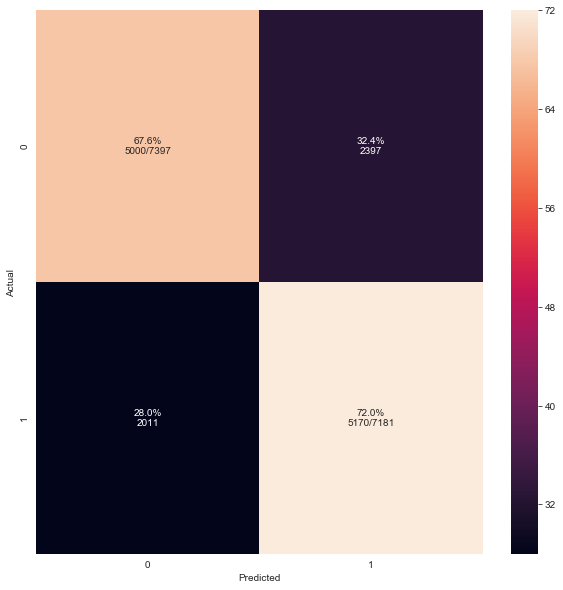

In [100]:
print ("Confusion matrix for Naive Bayes Bernoulli Model - Unemploymet:")
cm_analysis(y_testU, nb_un_preds_bernoulli, range(len(set(y_testU))), ymap=None, figsize=(10,10))

Confusion matrix for Naive Bayes Multinomial Model - Unemploymet:


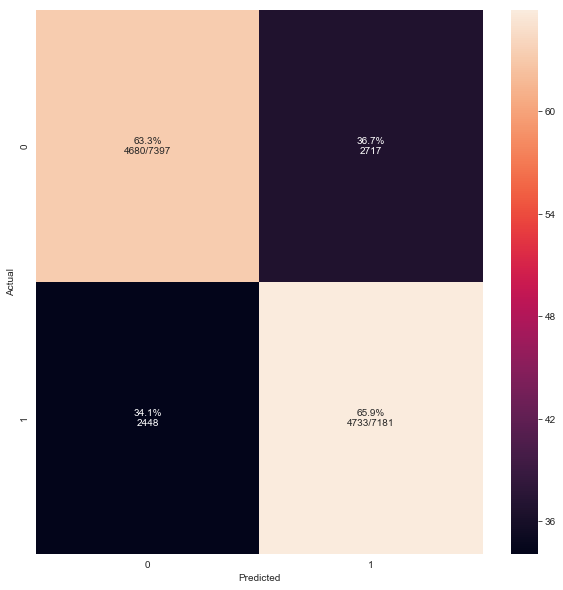

In [102]:
print ("Confusion matrix for Naive Bayes Multinomial Model - Unemploymet:")
cm_analysis(y_testU, nb_un_preds_multinomial, range(len(set(y_testU))), ymap=None, figsize=(10,10))

Confusion matrix for Naive Bayes Bernoulli Model - Child Poverty:


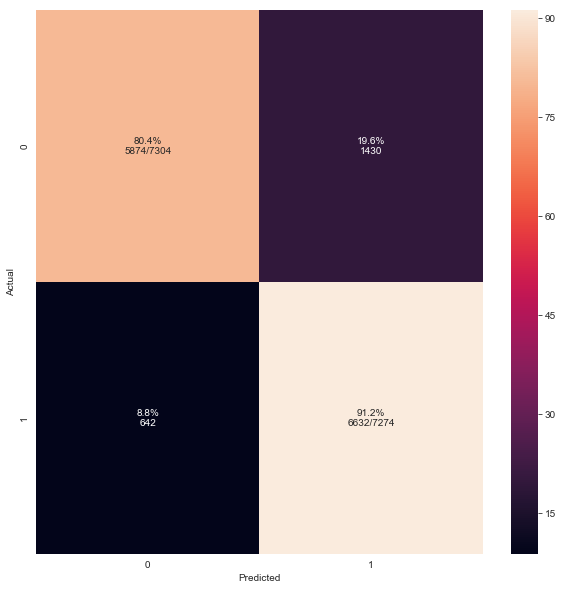

In [94]:
print ("Confusion matrix for Naive Bayes Bernoulli Model - Child Poverty:")
cm_analysis(y_testCP, nb_cp_preds_bernoulli, range(len(set(y_testCP))), ymap=None, figsize=(10,10))

Confusion matrix for Naive Bayes Multinomial Model - Child Poverty:


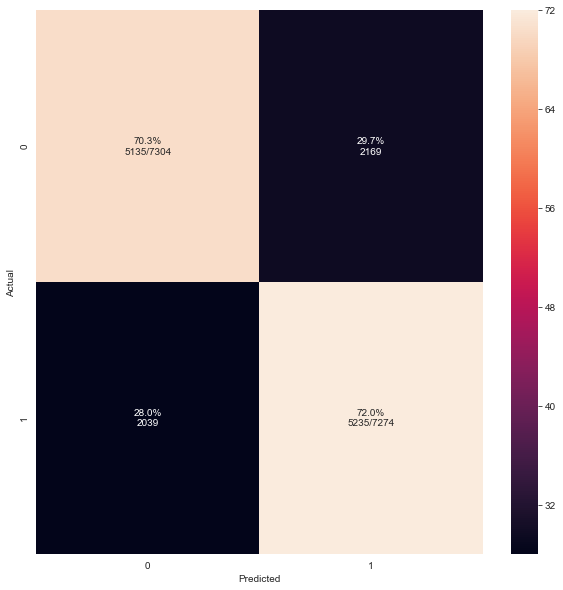

In [95]:
print ("Confusion matrix for Naive Bayes Multinomial Model - Child Poverty:")
cm_analysis(y_testCP, nb_cp_preds_multinomial, range(len(set(y_testCP))), ymap=None, figsize=(10,10))

Confusion matrix for Random Forest Model - Unemployment:


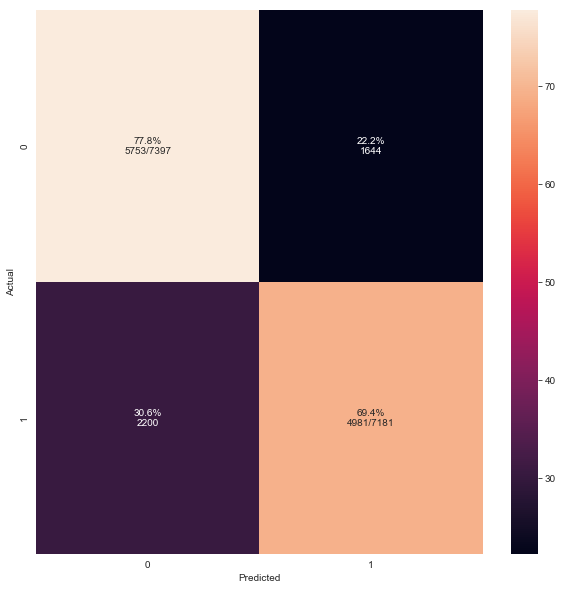

In [96]:
print ("Confusion matrix for Random Forest Model - Unemployment:")
cm_analysis(y_testU, rf_preds_un, range(len(set(y_testU))), ymap=None, figsize=(10,10))

Confusion matrix for Random Forest Model - Child Poverty:


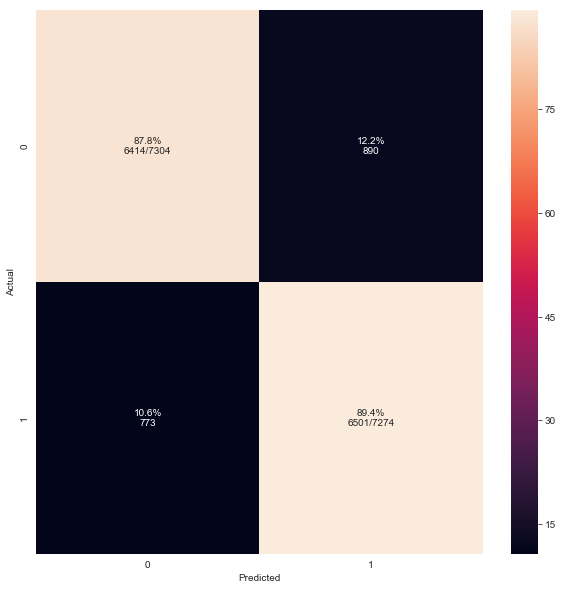

In [97]:
print ("Confusion matrix for Random Forest Model - Child Poverty:")
cm_analysis(y_testCP, rf_preds_cp, range(len(set(y_testCP))), ymap=None, figsize=(10,10))

# Modeling and Evaluation 5

<div class="alert alert-block alert-info">
<b>Rubric 7:</b> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
</div>

# Modeling and Evaluation 6

<div class="alert alert-block alert-info">
<b>Rubric 8:</b> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
</div>

# Deployment

<div class="alert alert-block alert-info">
<b>Rubric 9:</b> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 
</div>

# Exceptional Work

<div class="alert alert-block alert-info">
<b>Rubric 10:</b> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
</div>